## Introduction

This project aims to predict scenaries using computer vision techniques. While there are readily available pre-trained networks for deep learning, this project will demonstrate the use of SIFT and visual bag-of-words model without any deep learning to classify 1500 images into 15 classes. It aims to show that non deep learning techniques can still be useful when there is a lack of computational resources or that pre-trained networks are not available.

In [1]:
import pandas as pd
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

A few utilities functions for easy visualization of dataset

In [65]:
def load_Imagefromfile(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR) 
    return image

## To display one image

def cv2plt(img):
    plt.figure(figsize=(10,10))        # To change the size of figure
    plt.axis('on')
    if np.size(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)  
    plt.show()
    
def plot_images(images):
    num_images = len(images)
    num_cols = int(np.ceil(np.sqrt(num_images)))  # Calculate number of columns
    num_rows = int(np.ceil(num_images / num_cols))  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i, image in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image, cmap='gray')  # Assuming grayscale images
        ax.axis('off')

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
pathsegment = "."

In [4]:
directorylist = glob.glob(f'{pathsegment}/train/*')

Here, we split the 1500 training images into train and test set of 80:20 ratio.

In [5]:
from sklearn.model_selection import train_test_split

df_train = pd.DataFrame()
df_test = pd.DataFrame()
for directory in directorylist:
    imagepathlist =[path for path in glob.glob(f'{directory}/*')]
    target = [directory.split("/")[-1].split("\\")[-1]]*len(imagepathlist)
    df_part = pd.DataFrame({
        'Image':imagepathlist,
        'Target':target
    })
    train_part,test_part = train_test_split(df_part, test_size=0.2, random_state=42)
    df_train= pd.concat([train_part, df_train], axis = 0)
    df_test= pd.concat([test_part, df_test], axis = 0)
    
import os
import shutil
for directory in directorylist:
    
    target = directory.split("/")[-1].split("\\")[-1]
    
    train_dir = f"{pathsegment}/train_folder/{target}"
    test_dir = f"{pathsegment}/test_folder/{target}"

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        
    df_train_part = df_train.loc[df_train["Target"] == target]
    df_test_part = df_test.loc[df_test["Target"] == target]

    for index, row in df_train_part.iterrows():
        shutil.copy(row["Image"], train_dir)

    for index, row in df_test_part.iterrows():
        shutil.copy(row["Image"], test_dir)  

In [6]:
train_dirlist = [path for path in glob.glob(f"{pathsegment}/train_folder/*")]
test_dirlist = [path for path in glob.glob(f"{pathsegment}/test_folder/*")]

In [7]:
num_classes = df_train["Target"].nunique()

In [8]:
filepathlist =[path for path in glob.glob(f'{pathsegment}/train/*')]
tot_list = []
for filepath in filepathlist:
    imagelist = [path for path in glob.glob(f'{filepath}/*')]
    tot_list.extend(imagelist)

Visualize some samples from dataset

In [69]:
# create a samplelist with 2 images from each class
samplelist = []
for directory in train_dirlist:
    samplelist.extend([path for path in glob.glob(f'{directory}/*')][:2])

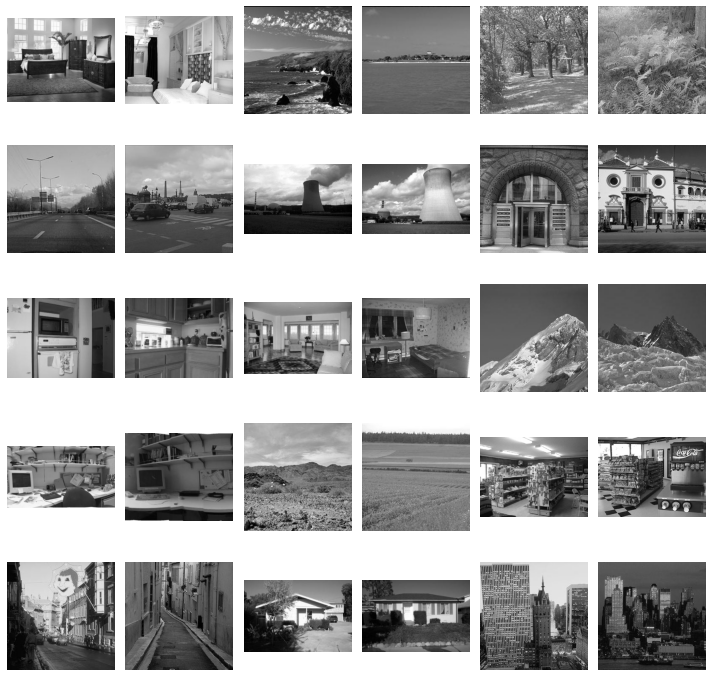

In [70]:
imgs = []
for imgpath in samplelist:
    imgs.append(load_Imagefromfile(imgpath))
plot_images(imgs)

SIFT (Scale-Invariant Feature Transform) is a popular computer vision algorithm used for extracting and describing local features in images. These features are invariant to scale, rotation, and partially invariant to changes in illumination and viewpoint. Here's a brief overview of how SIFT works:

1. Scale-space Extrema Detection: SIFT detects potential interest points in an image at multiple scales. It does this by convolving the image with Gaussian filters of different scales and then computing the difference of Gaussians (DoG) to identify local extrema in scale-space.
2. Keypoint Localization: Once potential interest points are identified, SIFT refines their locations by fitting a 3D quadratic function to the DoG function. This step helps in accurately localizing keypoints.
3. Orientation Assignment: SIFT assigns a dominant orientation to each keypoint based on local image gradients. This step makes the descriptors rotation-invariant.
4. Descriptor Calculation: Around each keypoint, SIFT computes a descriptor that captures information about the local image region. These descriptors are histograms of gradient orientations within localized image patches.

SIFT can be utilized for image classification as the features it extracted are not sensitive to exact intensity, yet able to capture image edges, contours and texture. It is also scale invariant, and partially translational and rotational invariant.

Lets visualize how SIFT extract descriptors from each class.

In [74]:
# create a samplelist with 1 images from each class
samplelist = []
for directory in train_dirlist:
    samplelist.extend([path for path in glob.glob(f'{directory}/*')][:1])

In [75]:
sift = cv2.SIFT_create()

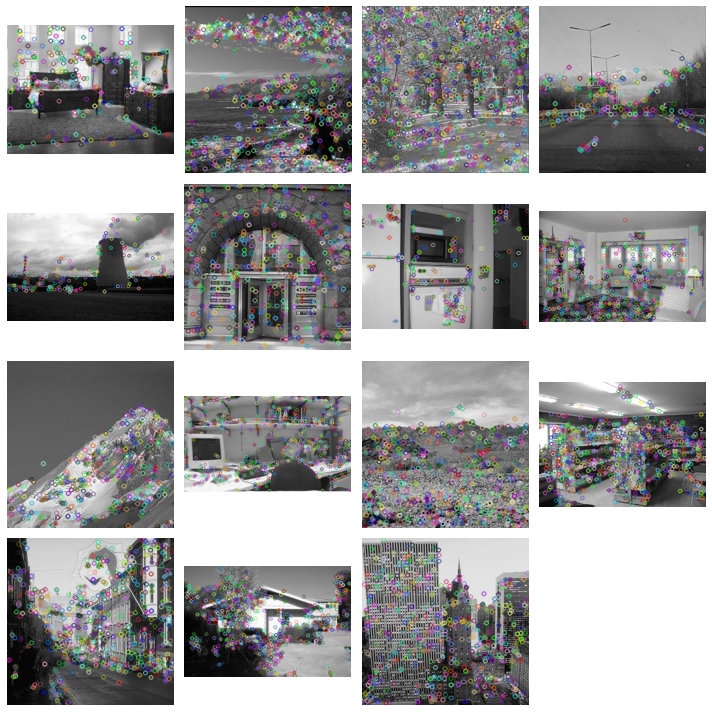

In [79]:
imgs = []
for imgpath in samplelist:
    img = load_Imagefromfile(imgpath)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img=cv2.drawKeypoints(img,keypoints,img)
    imgs.append(img)
plot_images(imgs)

In [80]:
 descriptors.shape

(545, 128)

### Compile descriptors for all images of train set

SIFT descriptors for all images in the train folder is compiled. The result is a n*128 array where n is the product of the number of training images and number of descriptors of each image.

In [15]:
from sklearn.cluster import KMeans

sift = cv2.SIFT_create()
des_arr = np.empty((0, 128))
for directory in train_dirlist:
    imagepathlist =[path for path in glob.glob(f'{directory}/*')]
    for imagepath in imagepathlist:
        image = load_Imagefromfile(imagepath)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        des_arr = np.vstack((des_arr, descriptors))

### Fit kmeans on SIFT descripters of train images

Conduct KMeans clustering trying out different k in intervals of 50. 50, 100, 150 and 300 are evaluated where k=150 achieved best training accuracy.

In [16]:
k = 150

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
kmeans.fit(des_arr.astype('double'))
labels = kmeans.labels_

### Construct code book from kmeans cluster centers

from k-means clustering, k number of cluster centers are obtained. The resulting codebook is a k*128 array. 

In [ ]:
codebook = kmeans.cluster_centers_

save codebook to csv so that we can use it during test

In [ ]:
codebook_dict = {}
for index, vector in enumerate(codebook):
    codebook_dict[index] = vector
codebook_df = pd.DataFrame.from_dict(codebook_dict, orient='index')
codebook_df.to_csv(f"codebook_{k}.csv", index = False, header = codebook_df.columns.tolist())

In [38]:
codebook = pd.read_csv(f"codebook_{k}.csv").values

### Construct histogram of visual words for train and test set

In [81]:
# compile image paths and target for train set
df_train_final = pd.DataFrame()

for directory in train_dirlist:
    imagepathlist =[path for path in glob.glob(f'{directory}/*')]
    target = [directory.split("/")[-1].split("\\")[-1]]*len(imagepathlist)
    df_part = pd.DataFrame({
        'Image':imagepathlist,
        'Target':target
    })
    df_train_final= pd.concat([df_part, df_train_final], axis = 0)

In [82]:
# compile image paths and target for test set
df_test_final = pd.DataFrame()

for directory in test_dirlist:
    imagepathlist =[path for path in glob.glob(f'{directory}/*')]
    target = [directory.split("/")[-1].split("\\")[-1]]*len(imagepathlist)
    df_part = pd.DataFrame({
        'Image':imagepathlist,
        'Target':target
    })
    df_test_final= pd.concat([df_part, df_test_final], axis = 0)

In [42]:
df_train_final.iloc[:1]

,Image,Target
0,./train_folder\TallBuilding\image_0011.jpg,TallBuilding


Next, histogram of visual words for both train and test set is constructed. For each descriptor of each image, the descriptor is repeated k times to form an array of k*128, thereafter the Euclidean distance is calculated between the descriptor (128 dim) and the codebook for each of the 300 rows of 128 dim per row. 

1. Conventionally, the row index with the smallest distance to descriptor is added to that image.

2. Here, we try another method whereby for each row index for the top n rows, the inverse distance of each descriptor is attributed.  This is to account for some cluster centers that are similar to descriptors do not get missed out. N = 5 shows the best training accuracy where top 5 row index with smallest distances are attributed to a descriptor.

In [ ]:
n = 5

In [43]:
image_df = pd.DataFrame()

for index, row in df_train_final.iterrows():
    image = load_Imagefromfile(row["Image"])
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    image_dict = {key: 0 for key in range(k)}
    for descriptor in descriptors:
        diff =  np.tile(descriptor, (k, 1)) - codebook  #300 rows, 128 dim
        dists = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        
        for i in range(n):
            image_dict[dists.argsort()[i]] += 1/dists[dists.argsort()[i]]

    heading = row["Target"]+"_"+str(index)
    image_df_part = pd.DataFrame.from_dict(image_dict, orient='index', columns = [heading] )
    image_df = image_df_part.merge(image_df, left_index=True, right_index=True, how = "outer")
    
image_df.fillna(0, inplace=True)
image_df_T = image_df.transpose()
image_df_T= image_df_T.reset_index()
image_df_T["target"] = image_df_T["index"].apply(lambda x : x.split("_")[0])
image_train_T = image_df_T[image_df_T.columns[~image_df_T.columns.isin(["index"])]]

In [44]:
image_df = pd.DataFrame()
for index, row in df_test_final.iterrows():
    image = load_Imagefromfile(row["Image"])
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    image_dict = {key: 0 for key in range(k)}
    for descriptor in descriptors:
#         descriptor = normalize_descriptors([descriptor])
        diff =  np.tile(descriptor, (k, 1)) - codebook
        dists = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        
        for i in range(n):
            image_dict[dists.argsort()[i]] += 1/dists[dists.argsort()[i]]
        
#         predicted_cluster = dist.argsort()[0]
#         image_dict[predicted_cluster] += 1

    heading = row["Target"]+"_"+str(index)
    image_df_part = pd.DataFrame.from_dict(image_dict, orient='index', columns = [heading] )
    image_df = image_df_part.merge(image_df, left_index=True, right_index=True, how = "outer")
    
image_df.fillna(0, inplace=True)
image_df_T = image_df.transpose()
image_df_T= image_df_T.reset_index()
image_df_T["target"] = image_df_T["index"].apply(lambda x : x.split("_")[0])
image_test_T = image_df_T[image_df_T.columns[~image_df_T.columns.isin(["index"])]]

In [45]:
image_train_T.describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.054514,0.052688,0.043498,0.058879,0.045121,0.043726,0.067361,0.060035,0.062858,0.049512,...,0.045223,0.084657,0.049325,0.056447,0.036164,0.050396,0.049243,0.051600,0.064808,0.072308
std,0.038623,0.045951,0.030251,0.057321,0.038030,0.036240,0.055744,0.043273,0.061982,0.037299,...,0.036223,0.047021,0.054625,0.043082,0.027576,0.047004,0.034453,0.047877,0.036943,0.039399
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025527,0.020887,0.021494,0.022806,0.018150,0.018288,0.028319,0.030292,0.025227,0.022078,...,0.018234,0.050412,0.014887,0.025960,0.014994,0.019696,0.024231,0.019710,0.038562,0.043379
50%,0.045775,0.040995,0.037431,0.046020,0.035593,0.035835,0.055110,0.050540,0.048561,0.041041,...,0.037018,0.077512,0.035697,0.047052,0.030788,0.037597,0.042706,0.038405,0.059082,0.066928
75%,0.076844,0.070963,0.059740,0.079126,0.062049,0.060317,0.091830,0.079098,0.079749,0.067320,...,0.063639,0.112711,0.064077,0.076281,0.051441,0.066212,0.065958,0.069304,0.084200,0.094216
max,0.213913,0.380736,0.206417,0.759373,0.448378,0.317704,0.460659,0.310223,0.968527,0.244623,...,0.224121,0.267846,0.900055,0.306519,0.148707,0.371277,0.291580,0.373762,0.221905,0.234353


### Target Labels

In [46]:
labelsdict = {
 'TallBuilding': 15,
 'Suburb': 14,
 'Street': 13,
 'store': 12,
 'OpenCountry': 11,
 'Office': 10,
 'Mountain': 9,
 'livingroom': 8,
 'kitchen': 7,
 'Insidecity': 6,
 'industrial': 5,
 'Highway': 4,
 'Forest': 3,
 'Coast': 2,
 'bedroom': 1
}

In [47]:
def converttarget(x, labelsdict):
    return labelsdict[x]

In [48]:
from sklearn.svm import SVC
# evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Pre-Processing

As SVM is affected by feature scaling, standardscaler is used to fit transform on train set and transform on test set. 

In [49]:
num_cols = image_train_T.columns[~image_train_T.columns.isin(["target"])]

In [60]:
preprocessor = ColumnTransformer([('num', StandardScaler(), num_cols)])

X_train_prepared = preprocessor.fit_transform(image_train_T[num_cols])
X_test_prepared = preprocessor.transform(image_test_T[num_cols])

y_train = np.array(image_train_T["target"].apply(lambda x : converttarget(x,labelsdict)))
y_test = np.array(image_test_T["target"].apply(lambda x : converttarget(x,labelsdict)))

### SVM on histogram with hyperparameters tuning using gridsearchCV

In [61]:
param_grid = {'kernel': ['rbf', 'poly'],
              'degree' : [2,3,4],
              'gamma': ['scale'],
              'C': [0.1, 0.5, 1, 2, 3, 5],
              "decision_function_shape" : ['ovo']
             }

#class weight balance for auto scaling of weights based on inverse frequency
svm_gs = GridSearchCV(estimator=SVC(class_weight='balanced'),
                      param_grid=param_grid, 
#                       scoring='f1_macro', 
                      scoring='accuracy', 
                      cv=5
                     )

svm_gs.fit(X_train_prepared, y_train)

print(svm_gs.best_params_)
print(svm_gs.best_score_)

params = {}
params['kernel'] = svm_gs.best_params_['kernel']
params['gamma'] = svm_gs.best_params_['gamma'] 
params['degree'] = svm_gs.best_params_['degree'] 
params['C'] = svm_gs.best_params_['C']
params["decision_function_shape"] = svm_gs.best_params_["decision_function_shape"]

final_mdl = SVC(**params,class_weight='balanced')
final_mdl 

{'C': 3, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.5225


SVC(C=3, class_weight='balanced', decision_function_shape='ovo', degree=2)

In [62]:
import pickle

def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [63]:
save_model(final_mdl, "trained_svm.pkl")

### Evaluation on test set

The best parameters are chosen for final model and evaluated on test set by confusion matrix.

              precision    recall  f1-score   support

           1       0.41      0.35      0.38        20
           2       0.50      0.65      0.57        20
           3       0.79      0.95      0.86        20
           4       0.50      0.80      0.62        20
           5       0.20      0.15      0.17        20
           6       0.62      0.50      0.56        20
           7       0.35      0.30      0.32        20
           8       0.44      0.40      0.42        20
           9       0.80      0.60      0.69        20
          10       0.48      0.60      0.53        20
          11       0.71      0.50      0.59        20
          12       0.50      0.50      0.50        20
          13       0.61      0.70      0.65        20
          14       0.95      0.95      0.95        20
          15       0.56      0.50      0.53        20

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56   

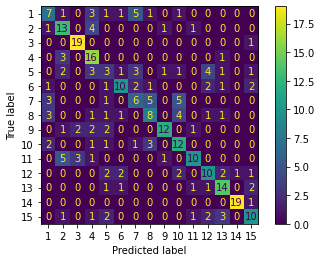

In [64]:
final_mdl.fit(X_train_prepared, y_train)
y_test_pred = final_mdl.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred, labels=final_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_mdl.classes_)
disp.plot()